# Approximating the semantic complexity of a sentence

<strong>Author:</strong> Alison Y. Kim

### Hale, John (2006). <em>Uncertainty About the Rest of the Sentence</em>, Cognitive Science 30 (2006), 643–672

"The [entropy reduction hypothesis] ERH might be glossed as saying that a person’s processing difficulty at a word in a sentence is proportional to the number of bits signaled to the person by that word with respect to a probabilistic grammar the person knows."<br>

"The [entropy reduction hypothesis], if correct, would offer just such an explanation. If a person’s difficulty on each word of a sentence is related to the amount of derivational information signaled by that word, then the total difficulty reading a sentence should be the sum of the difficulty on each word."

### Assumptions for the study

We make the simplifying assumption that the Hale's method to measure sentence difficulty (2003b, 2006) can be used to approximate sentential semantic complexity.<br>

Given a word $ w_{i} $ and its conditional entropy $ H(w_{i}) $, its <strong>entropy reduction</strong>, $ ER $, is given by
$$ ER = max(0, H(w_{i-1}) - H(w_{i})) $$

If $ w_{i} $ performs disambiguation relative to the preceding word $ w_{i-1} $, then $ H(w_{i-1}) > H(w_{i}) $ (equivalently, $ H(w_{i}) < H(w_{i-1}) $) and the difference $ H(w_{i-1}) - H(w_{i}) > 0 $. Otherwise, this difference is negative, and by definition, $ ER = 0 $.<br>

For a sentence $ S = \langle x_{1}, \dots, x_{n} \rangle $, its difficulty can be approximated by summing the over the difficulties on each word.

### Methods

To approximate token probabilities, we use <a href="https://huggingface.co/gpt2-large">GPT-2 large</a>, an English language model (LM). It is accessible via the Hugging Face framework.<br>

For tensor manipulation and operations, we use PyTorch.

### Calculation: Sentential semantic complexity

#### Import statements

In [1]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import seaborn as sns
import torch
from transformers import PreTrainedTokenizerFast, GPT2TokenizerFast, GPT2LMHeadModel
from scipy.stats import ttest_1samp


lm = GPT2LMHeadModel.from_pretrained('gpt2-large')
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-large')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alisonykim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Define sentences

Parallel corpora (```common``` = sentences with commonly appearing adverbs, ```rare``` = sentences with rarely appearing adverbs)

In [2]:
common = [
	'They looked at each other happily.',
	'The experienced doctor performed the operation sucessfully.',
	'She did not move, continuing to stare at me passionately.',
	'The dogs barked unexpectedly.',
	'The man on the boat waved angrily.',
	'One important person has been continuously absent.',
	'By the swimming pool, the neighbour waited nervously.',
	'It is so easy to be occasionally charitable.',
	'She clings to her marriage desperately.',
	'In this country, racism is spreading constantly.',
	'The little girl screamed and stamped her foot emotionally.',
	'The guests avoided all political discussion carefully.',
	'The day started normally.',
	'She grabbed the microphone stepped onto the stage confidently.',
	'They have been misleading you most unacceptably.',
	'To meet the deadline, the team worked efficiently.',
	'The student studied for the exam carefully.'
]

In [3]:
rare = [
	'They looked at each other amiably.',
	'The experienced doctor performed the operation dexterously.',
	'She did not move, continuing to stare at me belligerently.',
	'The dogs barked ferociously.',
	'The man on the boat waved affably.',
	'One important person has been conspicuously absent.',
	'By the swimming pool, the neighbour waited languidly.',
	'It is so easy to be vicariously charitable.',
	'She clings to her marriage tenaciously.',
	'In this country, racism has been spreading insidiously.',
	'The little girl screamed and stamped her foot petulantly.',
	'The guests avoided all political discussion sedulously.',
	'The day started mundanely.',
	'She grabbed the microphone and stepped onto the stage audaciously.',
	'They have been misleading you most egregiously.',
	'To meet the deadline, the team worked assiduously.',
	'The student studied for the exam sedulously.'
]

#### Calculate adverb surprisal
* <strong>Step 1:</strong> Tokenize sentences, i.e. map each token to an index in the LM's vocabulary.
	* <strong>Step 1.5:</strong> Extract the adverb from the sentence and tokenize it separately from the entire sentence. (Some words like "sedulously" are mapped to more than 1 item in GPT-2's vocabulary. Therefore, we must tokenize the adverb separately from the entire sentence. See: <strong>Note</strong>.)
* <strong>Step 2:</strong> Add \<BOS\> and <\EOS\> tokens to the sequence so that the probabilities we get are properly conditioned on the preceding tokens.
* <strong>Step 3:</strong> Calculate tokens' conditional logits (pre-softmax probabilities) under the LM.
* <strong>Step 4:</strong> Shift the label (token IDs) and logits tensors.
	* <strong>Logic:</strong> Here, we are interested in the <em>conditional</em> probabilities of words. Therefore, the conditional probability of \<BOS\> given previous tokens does not make sense to consider (there are no tokens preceding \<BOS\> in the sentence). Similarly, the probabilities over time steps after \<BOS\> are not of interest. The labels and logits tensors are shifted accordingly.
* <strong>Step 5:</strong> Calculate the negative log likelihood of the vocabulary item(s) corresponding to the adverb.
* <strong>Step 6:</strong> Extract the logits corresponding to the token position(s) of the adverb.

<strong>Note:</strong> Because some adverbs are mapped to more than 1 vocabulary item, the helper function below is designed to identify the vocabulary item(s) corresponding to the adverb.

In [4]:
def identify_adverb_ids(
    sent: str,
    tokenizer: PreTrainedTokenizerFast
) -> Union[Tuple[str, List[int], List[int]], Tuple[str, None]]:
    """
    Identify the vocabulary ID(s) corresponding to the adverb.
    
    Returns:
        Tuple of adverb vocabulary ID(s) and adverb token position(s)
    """
    sent_tokenized = nltk.word_tokenize(sent, language='english')
    adverb = sent_tokenized[-2] # Adverb always occupy penultimate sentence position
    sent_ids = [tokenizer.bos_token_id] + tokenizer(sent)['input_ids'] + [tokenizer.eos_token_id]
    # Reverse-engineer the encoding (via, surprise^, decoding) to find corresponding ID(s)
    # ^No pun intended
    for i in range(len(sent_ids)-1):
        curr_id_decoded = tokenizer.decode(sent_ids[i]).strip()
        next_id_decoded = tokenizer.decode(sent_ids[i+1]).strip()
        if curr_id_decoded == adverb:
            return adverb, [sent_ids[i]], [i]
        elif curr_id_decoded + next_id_decoded == adverb:
            return adverb, sent_ids[i:i+2], [i, i+1]
        elif len(curr_id_decoded + next_id_decoded) < len(adverb) and curr_id_decoded + next_id_decoded in adverb: # Substring in ```adverb``` but not equal
            try:
                next_next_id_decoded = tokenizer.decode(sent_ids[i+2]).strip()
                if curr_id_decoded + next_id_decoded + next_next_id_decoded == adverb:
                    return adverb, sent_ids[i:i+3], [i, i+1, i+2]
            except IndexError:
                return adverb, sent_ids[i:i+2], [i, i+1]
    return adverb, None

##### Common adverb sentences

In [5]:
adverb_surprisal_common = dict()
for sent in common:
	# Step 1
	sent_tokenized = tokenizer(sent)['input_ids']
	# Step 1.5
	adverb, adverb_tokenized, adverb_time_step = identify_adverb_ids(sent, tokenizer)
	# Step 2
	input_ids = torch.tensor([tokenizer.bos_token_id] + sent_tokenized + [tokenizer.eos_token_id])
	# Step 3
	with torch.no_grad():
		outputs = lm(input_ids, labels=input_ids)
	# Step 4
	labels_shifted = input_ids[..., 1:].contiguous()
	adverb_time_step_shifted = [time_step + 1 for time_step in adverb_time_step] # Shift time steps
	logits = outputs['logits']
	logits_shifted = logits[..., :-1, :].contiguous()
	assert logits_shifted.size(0) == labels_shifted.size(0) # As many labels as logits
	# Step 5
	nlls = -1 * torch.log_softmax(logits, dim=-1) # Token surprisal
	# Step 6
	adverb_surprisal_common[adverb] = [
		nlls[time_step][adverb_id].item()
		for time_step, adverb_id in zip(adverb_time_step_shifted, adverb_tokenized)
	]

In [6]:
adverb_surprisal_common

{'happily': [16.239721298217773],
 'sucessfully': [16.785587310791016, 20.889488220214844, 17.696590423583984],
 'passionately': [17.545166015625],
 'unexpectedly': [15.709169387817383],
 'angrily': [15.555511474609375],
 'absent': [12.684146881103516],
 'nervously': [15.868431091308594],
 'charitable': [11.97054672241211],
 'desperately': [13.908486366271973],
 'constantly': [15.275320053100586],
 'emotionally': [14.575103759765625],
 'carefully': [14.272598266601562],
 'normally': [15.229681015014648],
 'confidently': [16.01131820678711],
 'unacceptably': [18.11367416381836, 20.517274856567383, 18.268041610717773],
 'efficiently': [16.871641159057617]}

##### Rare adverb sentences

In [7]:
adverb_surprisal_rare = dict()
for sent in common:
	# Step 1
	sent_tokenized = tokenizer(sent)['input_ids']
	# Step 1.5
	adverb, adverb_tokenized, adverb_time_step = identify_adverb_ids(sent, tokenizer)
	# Step 2
	input_ids = torch.tensor([tokenizer.bos_token_id] + sent_tokenized + [tokenizer.eos_token_id])
	# Step 3
	with torch.no_grad():
		outputs = lm(input_ids, labels=input_ids)
	# Step 4
	labels_shifted = input_ids[..., 1:].contiguous()
	adverb_time_step_shifted = [time_step + 1 for time_step in adverb_time_step] # Shift time steps
	logits = outputs['logits']
	logits_shifted = logits[..., :-1, :].contiguous()
	assert logits_shifted.size(0) == labels_shifted.size(0) # As many labels as logits
	# Step 5
	nlls = -1 * torch.log_softmax(logits, dim=-1) # Token surprisal
	# Step 6
	adverb_surprisal_rare[adverb] = [
		nlls[time_step][adverb_id].item()
		for time_step, adverb_id in zip(adverb_time_step_shifted, adverb_tokenized)
	]

In [8]:
adverb_surprisal_rare

{'happily': [16.239721298217773],
 'sucessfully': [16.785587310791016, 20.889488220214844, 17.696590423583984],
 'passionately': [17.545166015625],
 'unexpectedly': [15.709169387817383],
 'angrily': [15.555511474609375],
 'absent': [12.684146881103516],
 'nervously': [15.868431091308594],
 'charitable': [11.97054672241211],
 'desperately': [13.908486366271973],
 'constantly': [15.275320053100586],
 'emotionally': [14.575103759765625],
 'carefully': [14.272598266601562],
 'normally': [15.229681015014648],
 'confidently': [16.01131820678711],
 'unacceptably': [18.11367416381836, 20.517274856567383, 18.268041610717773],
 'efficiently': [16.871641159057617]}

#### Calculate sentence entropies
* <strong>Steps 1-4:</strong> Same as in surprisal calculations.
* <strong>Step 5:</strong> Calculate sentential entropy, approximated as the sum of the token surprisals at each time step (token position).

##### Common adverb sentences

In [9]:
sent_ents_common = dict()
for sent in common:
	# Step 1
	tokenized = tokenizer(sent)['input_ids']
	# Step 2
	input_ids = torch.tensor([tokenizer.bos_token_id] + tokenized + [tokenizer.eos_token_id])
	# Step 3
	with torch.no_grad():
		outputs = lm(input_ids, labels=input_ids)
	# Step 4
	logits = outputs['logits']
	logits_shifted = logits[..., :-1, :].contiguous()
	# Step 5
	nlls = -1 * torch.log_softmax(logits, dim=-1) # Token surprisal
	probs = torch.softmax(logits, dim=-1) # Token probability under the LM
	entropies = torch.sum(nlls * probs, dim=-1) # Sequence distribution entropy
	sent_entropy = torch.sum(entropies, dim=-1) # Sentence entropy = sum over all tokens
	# Update dictionary
	sent_ents_common[sent_entropy] = sent

In [10]:
print('Summary: Common sentences')

for sent_ent, sent in sent_ents_common.items():
    print(f'{sent_ent.item()}\t{sent}')
print('')

ents_common = torch.tensor([ents for ents in sent_ents_common.keys()])
print(f'Mean: {torch.mean(ents_common)} bits')
print(f'Standard deviation: {torch.std(torch.tensor([ents for ents in sent_ents_common.keys()]))} bits')

Summary: Common sentences
35.48668670654297	They looked at each other happily.
54.327152252197266	The experienced doctor performed the operation sucessfully.
54.32371139526367	She did not move, continuing to stare at me passionately.
39.044029235839844	The dogs barked unexpectedly.
45.53729248046875	The man on the boat waved angrily.
49.21916961669922	One important person has been continuously absent.
57.38140869140625	By the swimming pool, the neighbour waited nervously.
51.66778564453125	It is so easy to be occasionally charitable.
43.43683624267578	She clings to her marriage desperately.
48.6048469543457	In this country, racism is spreading constantly.
53.35969924926758	The little girl screamed and stamped her foot emotionally.
52.76884078979492	The guests avoided all political discussion carefully.
35.31064987182617	The day started normally.
45.85140609741211	She grabbed the microphone stepped onto the stage confidently.
48.73605728149414	They have been misleading you most unaccept

Now, we determine whether the common sentences differ significantly in their respective semantic entropies. In other words, we test whether the mean of the entropies is 0.

$ H_{0, common} $: $ \mu_{common} = 0 $<br>

$ H_{A, common} $: $ \mu_{common} \neq 0 $

In [11]:
res_common = ttest_1samp(ents_common, popmean=0)
res_common

Ttest_1sampResult(statistic=28.287833268610353, pvalue=4.320132644800106e-15)

With a standard choice of $ \alpha = 0.05 $ and $ p = 4.320E^{-15} $, we can reject $ H_{0, common} $ in favor of $ H_{A, common} $.

##### Rare adverb sentences

In [12]:
sent_ents_rare = dict()
for sent in rare:
	# Step 1
	tokenized = tokenizer(sent)['input_ids']
	# Step 2
	input_ids = torch.tensor([tokenizer.bos_token_id] + tokenized + [tokenizer.eos_token_id])
	# Step 3
	with torch.no_grad():
		outputs = lm(input_ids, labels=input_ids)
	# Step 4
	logits = outputs['logits']
	logits_shifted = logits[..., :-1, :].contiguous()
	# Step 5
	nlls = -1 * torch.log_softmax(logits, dim=-1) # Token surprisal
	probs = torch.softmax(logits, dim=-1) # Token probability under the LM
	entropies = torch.sum(nlls * probs, dim=-1) # Sequence distribution entropy
	sent_entropy = torch.sum(entropies, dim=-1) # Sentence entropy = sum over all tokens
	# Update dictionary
	sent_ents_rare[sent_entropy] = sent

In [13]:
print('Summary: Rare sentences')

for sent_ent, sent in sent_ents_rare.items():
    print(f'{sent_ent.item()}\t{sent}')
print('')

ents_rare = torch.tensor([ents for ents in sent_ents_rare.keys()])
print(f'Mean: {torch.mean(ents_rare)}')
print(f'Standard deviation: {torch.std(ents_rare)}')

Summary: Rare sentences
35.99302673339844	They looked at each other amiably.
51.347206115722656	The experienced doctor performed the operation dexterously.
54.04316329956055	She did not move, continuing to stare at me belligerently.
38.73253631591797	The dogs barked ferociously.
47.96455764770508	The man on the boat waved affably.
43.1782112121582	One important person has been conspicuously absent.
57.78535461425781	By the swimming pool, the neighbour waited languidly.
52.48125457763672	It is so easy to be vicariously charitable.
43.61212158203125	She clings to her marriage tenaciously.
54.080589294433594	In this country, racism has been spreading insidiously.
53.07693099975586	The little girl screamed and stamped her foot petulantly.
53.41648483276367	The guests avoided all political discussion sedulously.
35.71513366699219	The day started mundanely.
50.89651107788086	She grabbed the microphone and stepped onto the stage audaciously.
45.259788513183594	They have been misleading you mo

Now, we determine whether the rare sentences differ significantly in their respective semantic entropies. In other words, we test whether the mean of the entropies is 0.

$ H_{0, rare} $: $ \mu_{rare} = 0 $<br>
$ H_{A, rare} $: $ \mu_{rare} \neq 0 $

In [14]:
res_rare = ttest_1samp(ents_rare, popmean=0)
res_rare

Ttest_1sampResult(statistic=27.604367307509776, pvalue=6.3419644294540635e-15)

With a standard choice of $ \alpha = 0.05 $ and $ p = 6.342E^{-15} $, we can reject $ H_{0, rare} $ in favor of $ H_{A, rare} $.

#### Distribution of sentence entropies: KDE plot

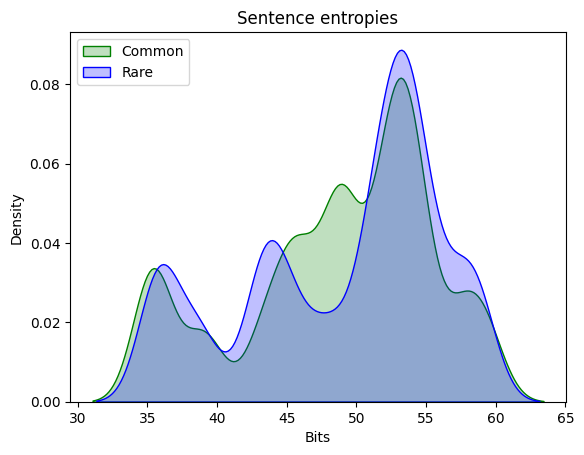

In [15]:
fig, ax = plt.subplots()

# Common
ents_common = torch.tensor([ents for ents in sent_ents_common.keys()])
sns.kdeplot(
    data=ents_common,
    ax=ax,
    bw_method=0.2,
    color='green',
    fill=True,
    label='Common'
);

# Rare
ents_rare = torch.tensor([ents for ents in sent_ents_rare.keys()])
sns.kdeplot(
    data=ents_rare,
    ax=ax,
    bw_method=0.2,
    color='blue',
    fill=True,
    label='Rare'
);

# Plot params
ax.set(title='Sentence entropies')
ax.legend(loc='upper left')
ax.set(xlabel='Bits');